In [ ]:
import h5py
import numpy as np
import cv2
import torch
import os
import pickle
import fnmatch
import cv2
import json
from time import time
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
import copy
import gc
from PIL import Image
from dataclasses import dataclass
from typing import List
from PIL import Image

def show_images_in_one_row(img_list: List[Image.Image]) -> None:
    """
    在 Jupyter Notebook 中同一行显示拼接的图像列表。

    :param img_list: 一个包含 PIL.Image.Image 的列表
    """
    if not img_list:
        raise ValueError("img_list 不能为空。")

    # 横向拼接图像
    widths, heights = zip(*(img.size for img in img_list))
    total_width = sum(widths)
    max_height = max(heights)

    # 创建容器图像
    combined_image = Image.new("RGB", (total_width, max_height), (255, 255, 255))  # 白色背景

    # 将图像粘贴到容器图像中
    x_offset = 0
    for img in img_list:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.size[0]

    # 在 Jupyter 中显示图像
    combined_image.show()

In [2]:

def show_images_in_one_row(img_list: List[Image.Image]) -> None:
    """
    在 Jupyter Notebook 中同一行显示拼接的图像列表。

    :param img_list: 一个包含 PIL.Image.Image 的列表
    """
    if not img_list:
        raise ValueError("img_list 不能为空。")

    # 横向拼接图像
    widths, heights = zip(*(img.size for img in img_list))
    total_width = sum(widths)
    max_height = max(heights)

    # 创建容器图像
    combined_image = Image.new("RGB", (total_width, max_height), (255, 255, 255))  # 白色背景

    # 将图像粘贴到容器图像中
    x_offset = 0
    for img in img_list:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.size[0]

    # 在 Jupyter 中显示图像
    display.display(combined_image)

In [3]:
NORMTYPE2CLASS = {
    'minmax': MinMaxNormalizer,
    'percentile': PercentileNormalizer, 
    'zscore': ZScoreNormalizer,
}

def flatten_list(l):
    return [item for sublist in l for item in sublist]

def get_episode_len(dataset_path_list, rank0_print=print):
    all_episode_len = []
    for dataset_path in dataset_path_list:
        try:
            with h5py.File(dataset_path, 'r') as root:
                elen = root['/episode_len'][0].astype(np.int32) if '/episode_len' in root else root['/action'][()].shape[0]
        except Exception as e:
            rank0_print(f'Error loading {dataset_path} in get_episode_len')
            rank0_print(e)
            quit()
        all_episode_len.append(elen) 
    return all_episode_len

@dataclass
class DArgs:
    chunk_size: int=50
    abs_control: bool=True
    image_size_primary: str='(480, 640)'
    image_size_wrist: str = '(480, 640)'



class EpisodicDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path_list, camera_names=['cam_high', 'cam_left_wrist', 'cam_right_wrist'], action_normalizers={}, state_normalizers={}, data_args={}, control_space='joint'):
        super(EpisodicDataset).__init__()
        self.episode_ids = np.arange(len(dataset_path_list))
        self.dataset_path_list = dataset_path_list
        self.action_normalizers = action_normalizers
        self.state_normalizers = state_normalizers
        self.camera_names = camera_names
        self.chunk_size = data_args.chunk_size
        self.episode_len = get_episode_len(dataset_path_list)
        self.cumulative_len = np.cumsum(self.episode_len)
        self.max_episode_len = max(self.episode_len)
        self.data_args = data_args
        self.control_space = control_space
        self.augment_images = False
        self.transformations = None
        # a = self.__getitem__(0) # initialize self.is_sim and self.transformations

    def __len__(self):
        return sum(self.episode_len)

    def _locate_transition(self, index):
        assert index < self.cumulative_len[-1]
        episode_index = np.argmax(self.cumulative_len > index) # argmax returns first True index
        start_ts = index - (self.cumulative_len[episode_index] - self.episode_len[episode_index])
        episode_id = self.episode_ids[episode_index]
        return episode_id, start_ts
    
    def load_from_h5(self, dataset_path, start_ts, episode_len): 
        with h5py.File(dataset_path, 'r') as root:
            # 加载文本
            if 'language_instruction' in root:
                raw_lang = root['language_instruction'][0].decode('utf-8')
            else:
                raw_lang = ''
            # 加载动作 & 状态
            action_start = max(0, start_ts - 1)
            action = root[f'/action'][action_start:action_start+self.data_args.chunk_size]
            if self.data_args.abs_control:
                state = root[f'/observations/qpos'][action_start]
            else:
                states = root[f'/observations/qpos'][action_start:action_start+self.data_args.chunk_size]
                action[:, :-1] = action[:, :-1] - states[:, :-1]
                state = states[0]
            # 加载图像
            image_dict = dict()
            for cam_name in self.camera_names:
                img_bytes = root[f'/observations/images/{cam_name}'][start_ts]
                image_dict[cam_name] = cv2.imdecode(np.frombuffer(img_bytes, np.uint8), cv2.IMREAD_COLOR)
                img_size = self.data_args.image_size_primary if 'wrist' not in cam_name else self.data_args.image_size_wrist
                image_dict[cam_name] = cv2.resize(image_dict[cam_name], eval(img_size))
            reasoning = ""
        return action, image_dict, state, raw_lang, reasoning
    
    def __getitem__(self, index):
        episode_id, start_ts = self._locate_transition(index)
        dataset_path = self.dataset_path_list[episode_id]
        episode_len = self.episode_len[episode_id]
        try:
            action, image_dict, state, raw_lang, reasoning = self.load_from_h5(dataset_path, start_ts, episode_len)
        except Exception as e:
            print(f"Read {dataset_path} happens {YELLOW}{e}{RESET}")
            try:
                dataset_path = self.dataset_path_list[episode_id + 1]
            except Exception as e:
                dataset_path = self.dataset_path_list[episode_id - 1]
            action, image_dict, state, raw_lang, reasoning = self.load_from_h5(dataset_path, start_ts, episode_len)
        padded_action = np.zeros((self.data_args.chunk_size, action.shape[1]), dtype=np.float32) # padding动作到完整的维度
        padded_action[:action.shape[0]] = action
        is_pad = np.zeros(self.data_args.chunk_size) # 标注哪些位置的动作是padding的，不加入计算
        is_pad[action.shape[0]:] = 1
        # new axis for different cameras
        all_cam_images = []
        for cam_name in self.camera_names:
            all_cam_images.append(image_dict[cam_name])
        all_cam_images = np.stack(all_cam_images, axis=0) #把img叠成一个array
        
        # normalize data
        action_normalizer = self.action_normalizers.get(os.path.dirname(dataset_path), None)
        # assert , f"no normalizer found for dataset dir {os.path.dirname(dataset_path)}"
        if action_normalizer is not None:
            action_data = action_normalizer.normalize(padded_action, space_name=self.control_space, datatype='action', is_delta=not self.data_args.abs_control)
        else:
            action_data = padded_action
        state_normalizer = self.state_normalizers.get(os.path.dirname(dataset_path), None)
        # assert state_normalizer is not None, f"no normalizer found for dataset dir {os.path.dirname(dataset_path)}"
        if state_normalizer is not None:
            state_data = state_normalizer.normalize(state, space_name=self.control_space, datatype='state', is_delta=False)
        else:
            state_data = state
        # construct observations， 把array转成tensor
        image_data = torch.from_numpy(all_cam_images)
        state_data = torch.from_numpy(state_data).float()
        action_data = torch.from_numpy(padded_action).float()
        is_pad = torch.from_numpy(is_pad).bool()
        image_data = torch.einsum('k h w c -> k c h w', image_data) # 把图像交换通道

        sample = {
            'image': image_data,
            'state': state_data,
            'action': action_data,
            'is_pad': is_pad,
            'raw_lang': raw_lang,
            'reasoning': reasoning
        } # 构造样本dict
        assert raw_lang is not None, ""
        del image_data
        del state_data
        del action_data
        del is_pad
        del raw_lang
        del reasoning
        gc.collect()
        torch.cuda.empty_cache()
        return sample



In [4]:
data_args = DArgs()
data_dir = "/inspire/hdd/project/robot-action/public/data/red_cube_and_blue_cup/success_3"
data_list = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.hdf5')]
dataset = EpisodicDataset(data_list, data_args=data_args)

In [5]:
def get_image_from_sample(sample):
    imgs = sample['image'].permute(0, 2, 3, 1).numpy()
    return [Image.fromarray(img) for img in imgs]

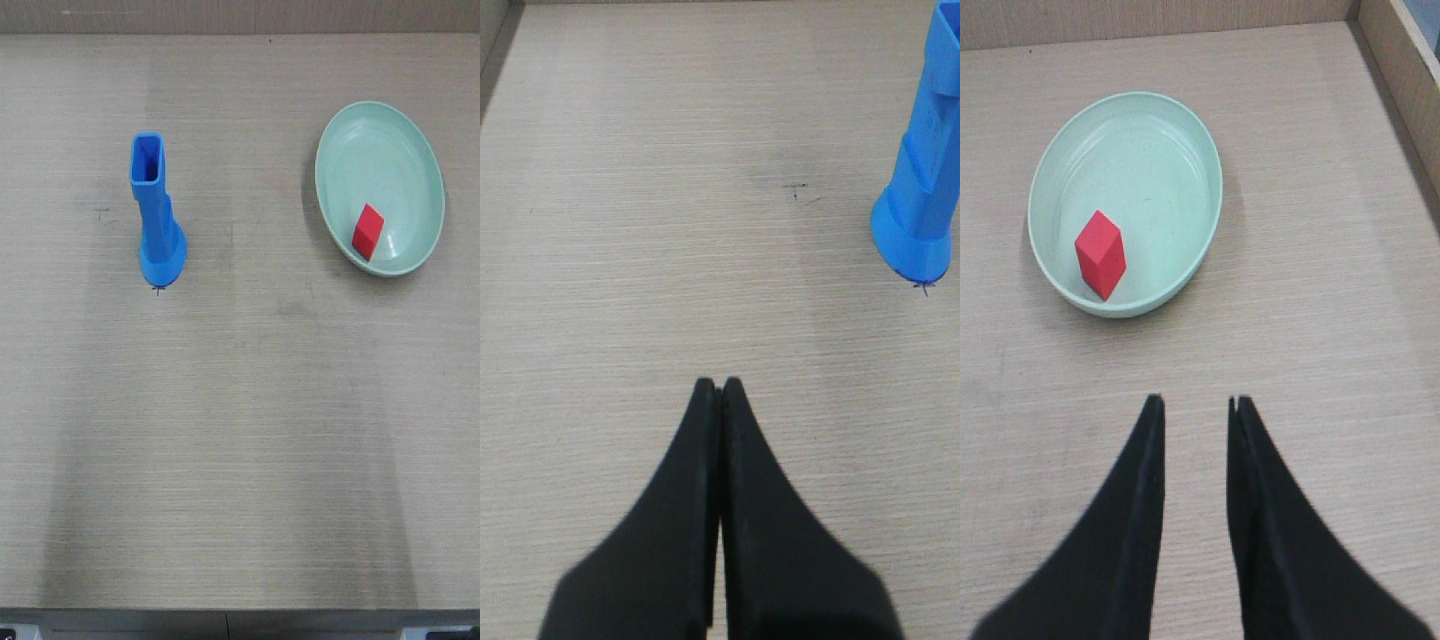

In [6]:
from data_utils.cooker.augmentation import *
sraw = dataset[0]
img_raw = get_image_from_sample(sraw)
show_images_in_one_row(img_raw)

# 几何增强

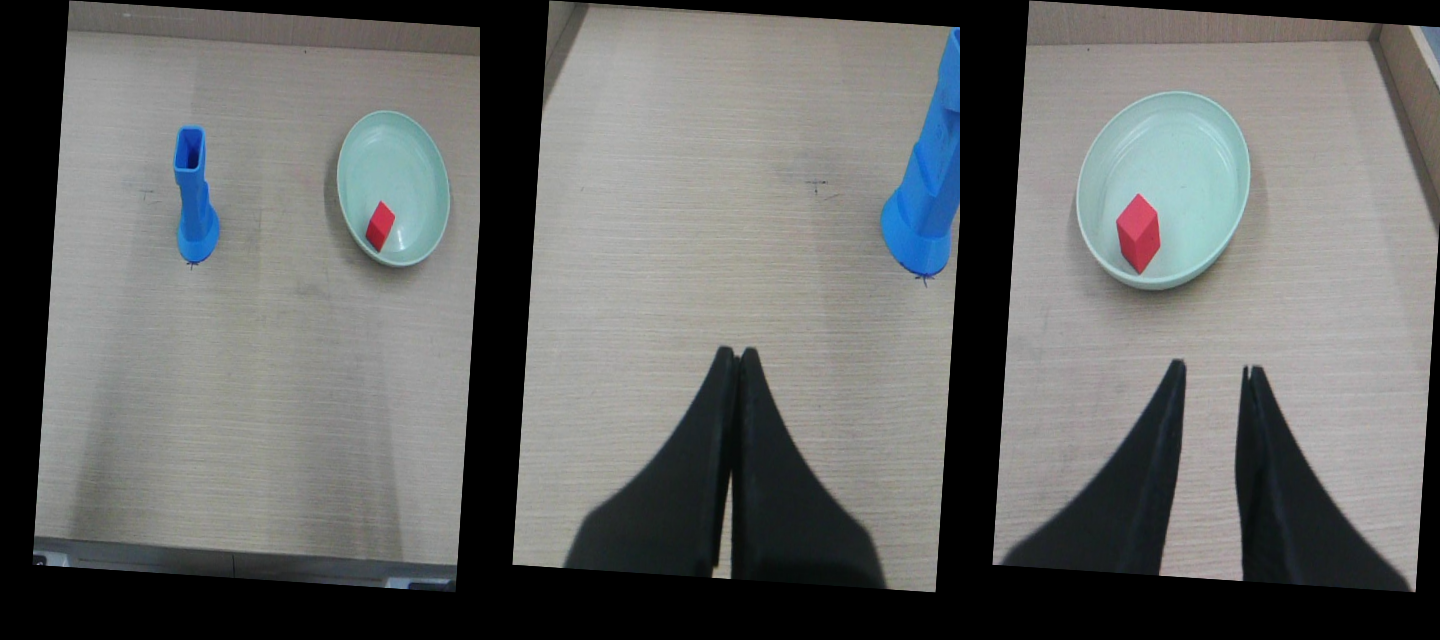

In [7]:
# geo
geo_aug_dataset = GeometricTransformationDataset(dataset, p_aug=0.9)
s = geo_aug_dataset[0]
img = get_image_from_sample(s)
show_images_in_one_row(img)

# 颜色增强

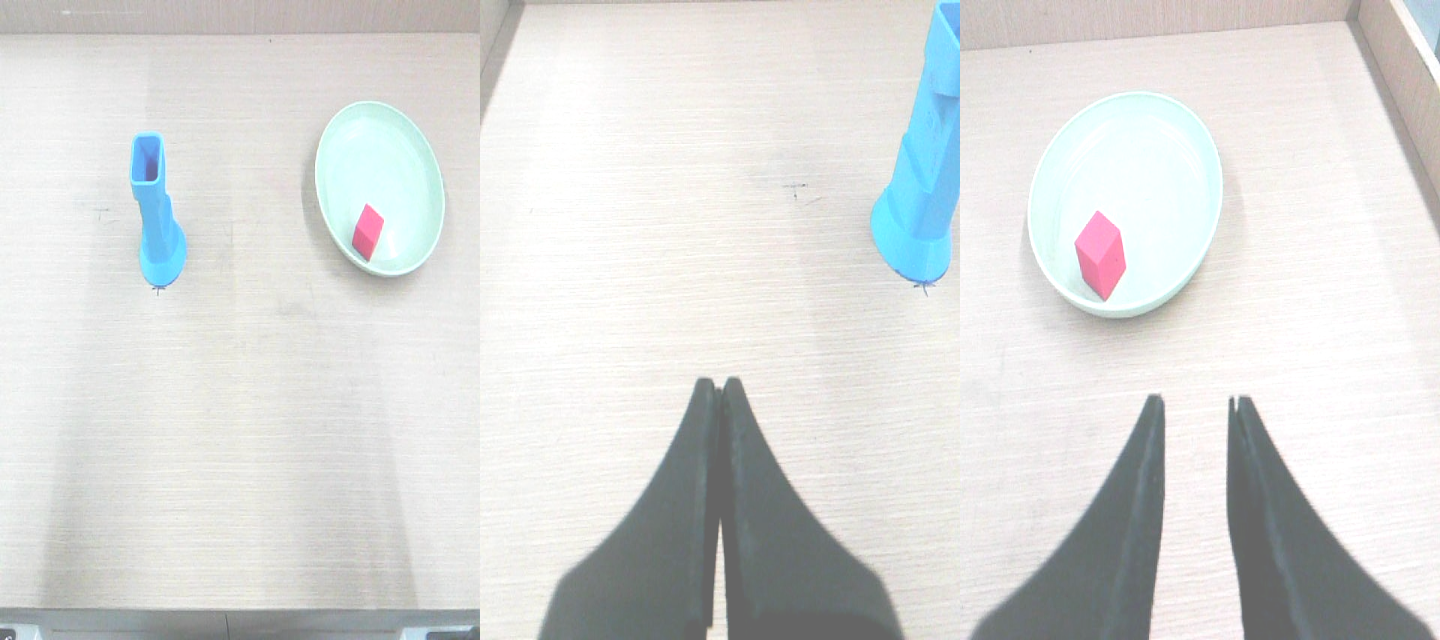

In [17]:
color_aug_data = ColorJitteringDataset(dataset, p_aug=0.9)
s = color_aug_data[0]
img = get_image_from_sample(s)
show_images_in_one_row(img)

# 对抗扰动

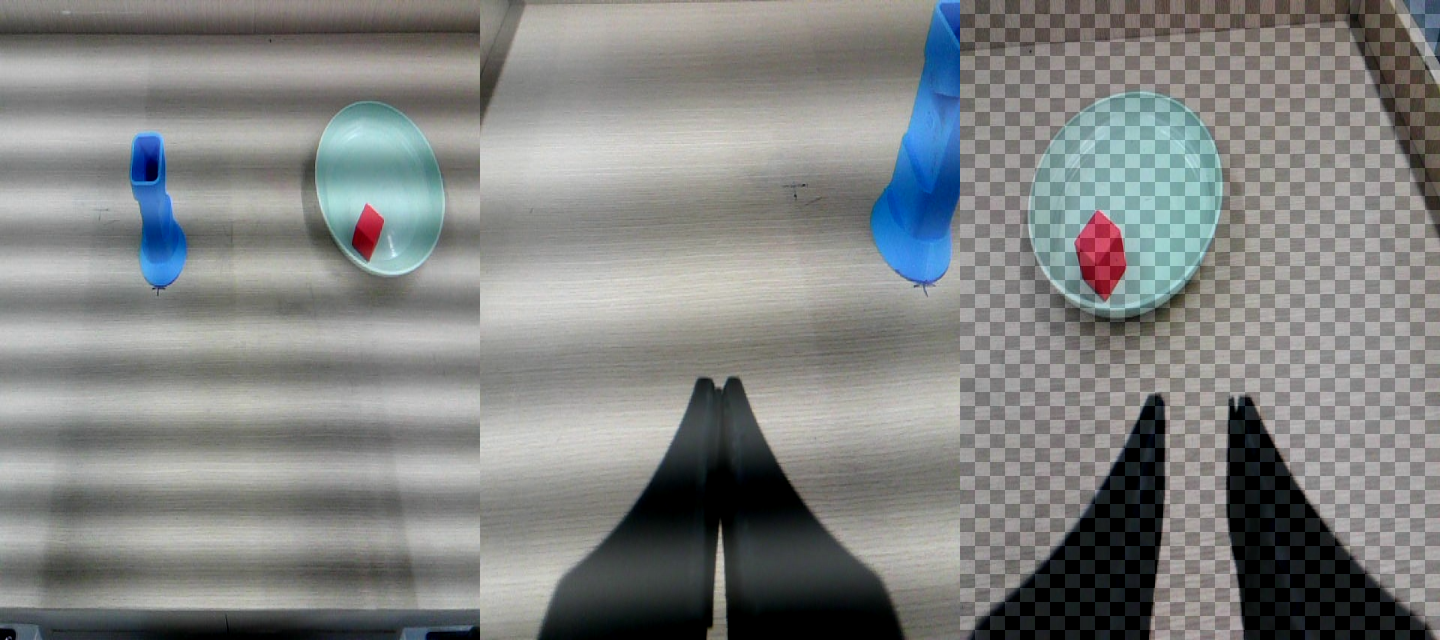

In [14]:
ad_aug_data = AdversaryDataset(dataset, p_aug=0.9)
s = ad_aug_data[0]
img = get_image_from_sample(s)
show_images_in_one_row(img)